In [163]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.model_selection import StratifiedKFold, train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix, plot_roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import pickle

# import warnings
import warnings
warnings.filterwarnings('ignore')

In [164]:
# import data
df = pd.read_csv('heart_2020_cleaned.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


The aim of the project is the build and develop an AI powered heart disease prediction system. The target variable for this project will be the column "HeartDisease".

In [165]:
# check value counts of target variable
df['HeartDisease'].value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [166]:
# also check ratio of target variable
df['HeartDisease'].value_counts(normalize=True)

No     0.914405
Yes    0.085595
Name: HeartDisease, dtype: float64

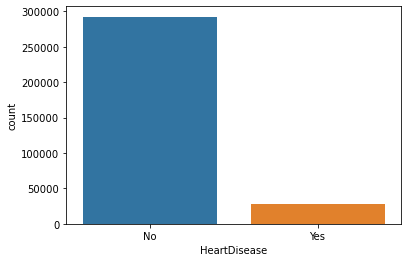

In [167]:
# plot target variable
sns.countplot(x='HeartDisease', data=df)
plt.show()

We see that we have an imbalance in the target variable. We have 27373 cases of heart disease and 292422 cases of no heart disease. We will need to take this into account when we build our model.

In [168]:
# check missing values
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [169]:
# check duplicates
df.duplicated().sum()

18078

In [170]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [171]:
# check data types
df.dtypes

HeartDisease         object
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

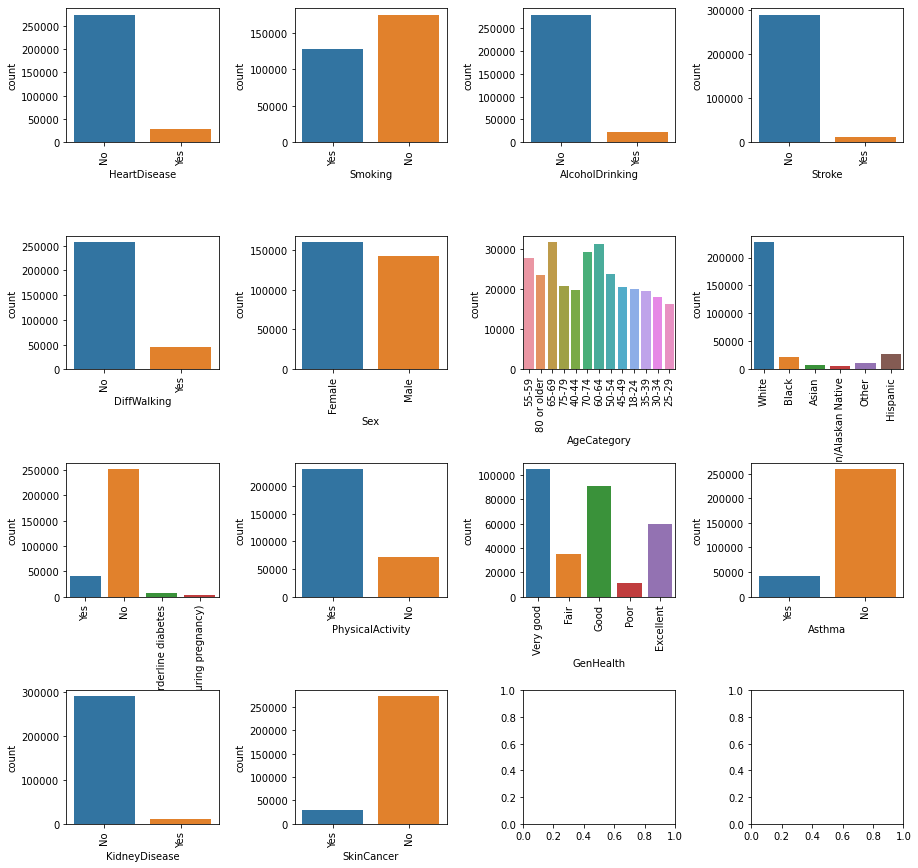

In [172]:
# bar plot of all categorical variables
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
fig.subplots_adjust(hspace=0.7, wspace=0.5)

for variable, subplot in zip(df.select_dtypes('object').columns, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
plt.show()

We do countplots for all categorical variables in a dataset so that we can get a sense of the distribution of categories in each variable, and identify any imbalances or unusual patterns in the data.

Observations:
- Significant imbalance in Heart Disease, Alcolhol drinking, Stroke, DIff Walking, Race, Diabetic, Asthma, Kidney Disease, and Skin Cancer.
- Age categories are evenly distributed with slightly more weighing towards the older age groups.
- People tend to marke themselvers higher on general health.

BMI skewness: 1.2977369892755388
BMI kurtosis: 3.690674216754272
PhysicalHealth skewness: 2.500999806293472
PhysicalHealth kurtosis: 4.971244060094088
MentalHealth skewness: 2.237469970526929
MentalHealth kurtosis: 3.9385382757201315
SleepTime skewness: 0.6972236513747475
SleepTime kurtosis: 7.572206496845394


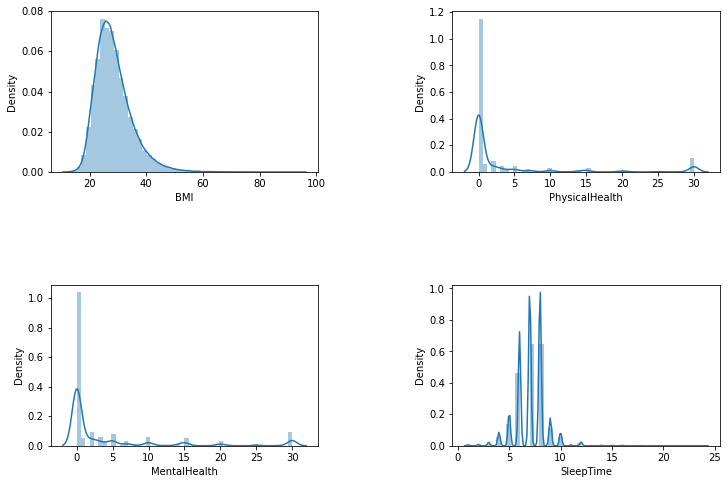

In [173]:
# distribution plot of all numerical columns
fig, ax = plt.subplots(2,2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.7, wspace=0.5)
for variable, subplot in zip(df.select_dtypes('float64').columns, ax.flatten()):
    sns.distplot(df[variable], ax=subplot)
    print(variable, 'skewness:', df[variable].skew())
    print(variable, 'kurtosis:', df[variable].kurtosis())
plt.show()

We create distribution plots for all numerical columns in a datasets so that we can get a sense of the range and spread of each variable, as well as any unusual patterns or outliers in the data.

Observations:
- Presence of positive skewness in all numerical variables.
- BMI is the most normally as well as densely distributed variable.

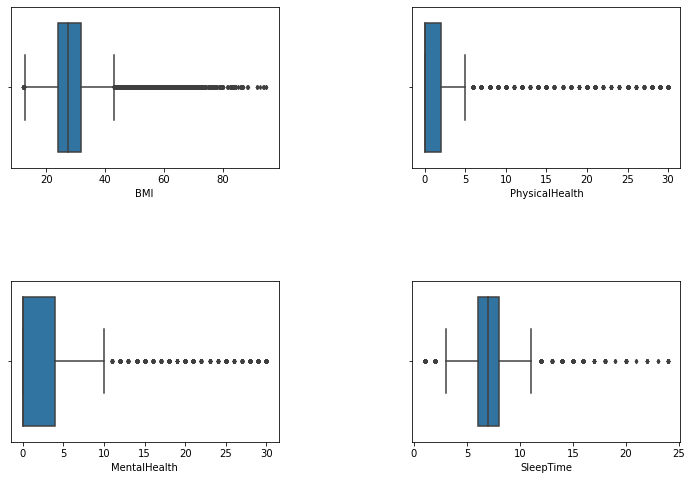

In [174]:
# check outliers in all numerical columns
fig, ax = plt.subplots(2,2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.7, wspace=0.5)
for variable, subplot in zip(df.select_dtypes('float64').columns, ax.flatten()):
    sns.boxplot(df[variable], ax=subplot, fliersize=3)
plt.show()

We create box plots for all numerical columns in the dataset so that we can get a more detailed sense of the spread and variability of each variable, and identify any patterns or outliers that might be relevant to our problem.

Observations:
- Presence of outliers in all numerical variables.

In [175]:
# drop outliers using 3 standard deviation from the mean of the values
for col in df.select_dtypes('float64').columns:
    mean = df[col].mean()
    std = df[col].std()
    df = df[(df[col] > mean - 3 * std) & (df[col] < mean + 3 * std)]

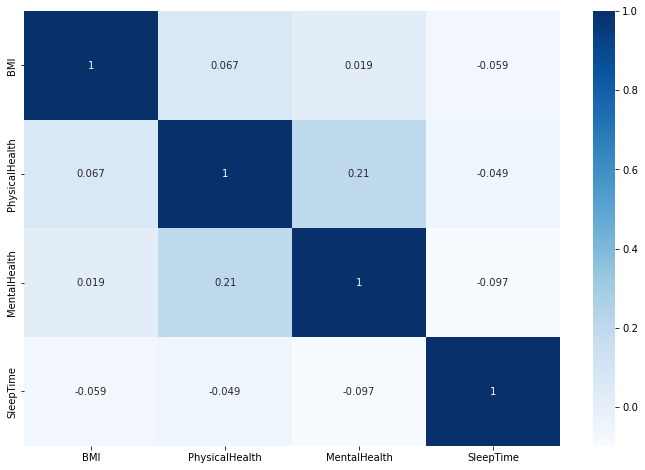

In [176]:
# check correlation using heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.show()

We see that all numerical features show strong signs of independence from each other. This is a good sign as it means that we can use all of the features in our model. We can although see a slight positive correlation between Mental Health and Physical Health.

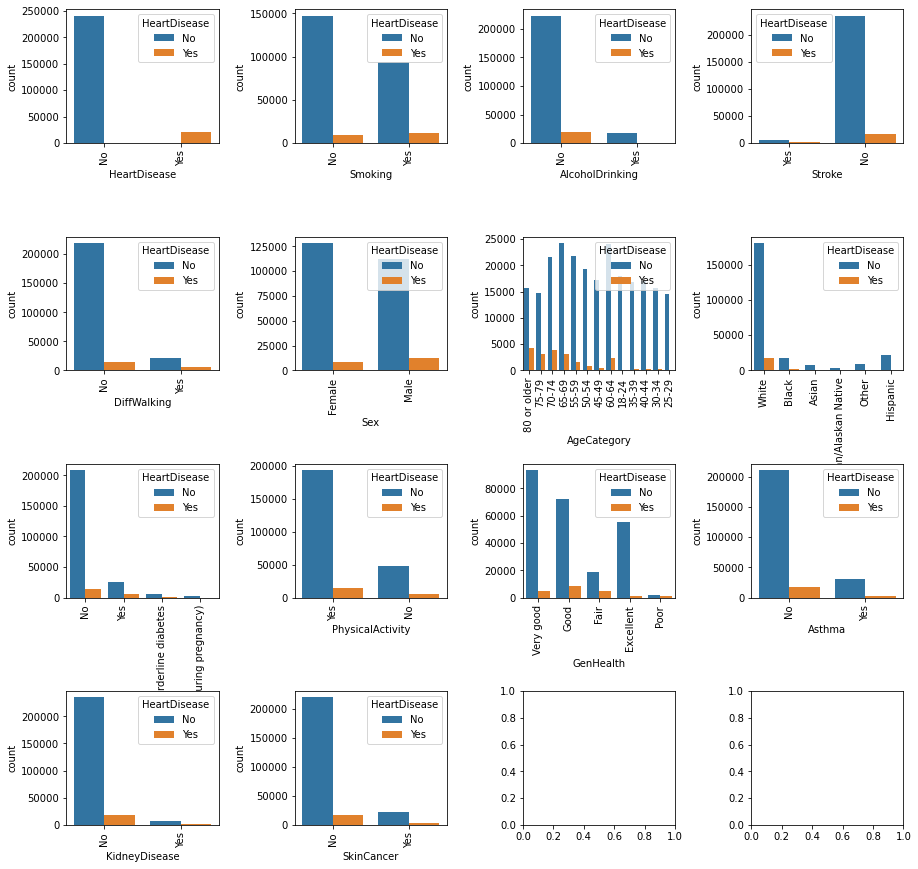

In [177]:
# check bar plots of all categorical variables with target variable
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
fig.subplots_adjust(hspace=0.7, wspace=0.5)

# make plots
for variable, subplot in zip(df.select_dtypes('object').columns, ax.flatten()):
    sns.countplot(df[variable], hue=df['HeartDisease'], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [178]:
# check correlation of all categorical variables with target variable using chi-square test
cat_vars = list(df.select_dtypes('object').columns)

# empty dataframe to store results
chi_df = pd.DataFrame(columns=['Feature', 'Chi-squared', 'P-value'])

# calculate chi-squared and p-value
for var in cat_vars:
    contingency_table = pd.crosstab(df[var], df['HeartDisease'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_df = chi_df.append({'Feature': var, 'Chi-squared': chi2, 'P-value': p}, ignore_index=True)

# Sort results by p-value in ascending order
chi_df.sort_values(by='P-value', inplace=True)

chi_df

,Feature,Chi-squared,P-value
0,HeartDisease,261273.134058,0.000000e+00
1,Smoking,2377.541969,0.000000e+00
3,Stroke,7449.409974,0.000000e+00
4,DiffWalking,6726.515973,0.000000e+00
5,Sex,1593.831834,0.000000e+00
6,AgeCategory,16284.567860,0.000000e+00
8,Diabetic,6977.962266,0.000000e+00
10,GenHealth,12097.583655,0.000000e+00
12,KidneyDisease,3924.725184,0.000000e+00
13,SkinCancer,2152.029587,0.000000e+00


We see that all categorical variables are statistically significant in predicting the target variable. This is a good sign as it means that we can use all of the features in our model.

In [185]:
# pearson r correlation test on all numerical variables with target variable
num_vars = list(df.select_dtypes('float64').columns)

# empty dataframe to store results
corr_df = pd.DataFrame(columns=['Feature', 'Correlation', 'P-value'])

# calculate correlation and p-value
for var in num_vars:
    corr, p = pearsonr(df[var], df['HeartDisease'].map({'No': 0, 'Yes': 1}))
    corr_df = corr_df.append({'Feature': var, 'Correlation': corr, 'P-value': p}, ignore_index=True)

# Sort results by p-value in ascending order
corr_df.sort_values(by='P-value', inplace=True)

corr_df

,Feature,Correlation,P-value
1,PhysicalHealth,0.097001,0.000000e+00
0,BMI,0.044313,1.057570e-113
2,MentalHealth,-0.026265,4.142727e-41
3,SleepTime,0.017326,8.219005e-19


In [186]:
# label encode categorical columns and create dictionary to reverse encoding

le = LabelEncoder()
col_map_dict = {}

for col in df.select_dtypes('object').columns:
    df[col] = le.fit_transform(df[col])
    col_map_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [187]:
# define X and y
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [188]:
# define default models to build
models_dict = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1)
}

We do a Stratified K-Fold cross validation on the dataset. We use Stratified K-Fold cross validation because we have an imbalance in the target variable. 

We experiment using all 4 models with Imbalance vs Undersampling vs SMOTE (Synthetic Minority Oversampling Technique).

In [189]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models_dict.items():

    imb_f1_list_train = []
    us_f1_list_train = []
    smote_f1_list_train = []
    
    imb_f1_list_test = []
    us_f1_list_test = []
    smote_f1_list_test = []

    # Iterate through the cross-validation splits
    for train_index, test_index in cv.split(X, y):
        # Split the data into train and test sets
        X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
        y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]

        rus = RandomUnderSampler(random_state=42)
        X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
        model.fit(X_train_res, y_train_res)
        # get predictions on test data
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        us_f1_list_test.append(f1)
        us_f1_list_train.append(f1_score(y_train, model.predict(X_train)))


        # Fit the model on the training data
        model.fit(X_train, y_train)
        # get predictions on test data
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        imb_f1_list_test.append(f1)
        imb_f1_list_train.append(f1_score(y_train, model.predict(X_train)))

        # Apply SMOTE on the training set and train model
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        model.fit(X_train_res, y_train_res)
        # get predictions on test data
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        smote_f1_list_test.append(f1)
        smote_f1_list_train.append(f1_score(y_train, model.predict(X_train)))

    print("\n\n" + model_name)
    print('\nImbalance data Test f1 score:', np.mean(imb_f1_list_test))
    print('Imbalance data Train f1 score:', np.mean(imb_f1_list_train))
    print('\nRUS data Test f1 score:', np.mean(us_f1_list_test))
    print('RUS data Train f1 score:', np.mean(us_f1_list_train))
    print('\nSMOTE data Test f1 score:', np.mean(smote_f1_list_test))
    print('SMOTE data Train f1 score:', np.mean(smote_f1_list_train))



Logistic Regression

Imbalance data Test f1 score: 0.1041759753495537
Imbalance data Train f1 score: 0.10438571359001618

RUS data Test f1 score: 0.30460412354583466
RUS data Train f1 score: 0.3046684279438299

SMOTE data Test f1 score: 0.30442681180376935
SMOTE data Train f1 score: 0.30469586484097466


Decision Tree

Imbalance data Test f1 score: 0.2140893208212503
Imbalance data Train f1 score: 0.9772999909599107

RUS data Test f1 score: 0.2372580351230233
RUS data Train f1 score: 0.3554502925360731

SMOTE data Test f1 score: 0.210251667275543
SMOTE data Train f1 score: 0.9773002813660504


Random Forest

Imbalance data Test f1 score: 0.13136583778471592
Imbalance data Train f1 score: 0.9770219923999317

RUS data Test f1 score: 0.2942355794536002
RUS data Train f1 score: 0.38867771383777966

SMOTE data Test f1 score: 0.15801821421985668
SMOTE data Train f1 score: 0.9776160586226329


XGBoost

Imbalance data Test f1 score: 0.11349579956855846
Imbalance data Train f1 score: 0.185353

We see that we are able to get the best generalized score on Testing set using XGBoost and Random Undersampling. We will further hyper parameter tune XGBoost to get the best possible score.

In [190]:
# hyperparameter tuning for XGBoost and Random under sampling

model = models_dict['XGBoost']
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# param grid
param_grid = {
    'max_depth': [None, 3, 6, 10],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [None, 50, 100, 500]
}

# grid search
grid_search = GridSearchCV(model, param_grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=True)
grid_search.fit(X_res, y_res)

# best model
best_model = grid_search.best_estimator_
print(grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


F1: 0.31197798484043837
ROC AUC: 0.756063425625115
              precision    recall  f1-score   support

           0       0.98      0.72      0.83     48169
           1       0.19      0.79      0.31      4089

    accuracy                           0.73     52258
   macro avg       0.59      0.76      0.57     52258
weighted avg       0.91      0.73      0.79     52258



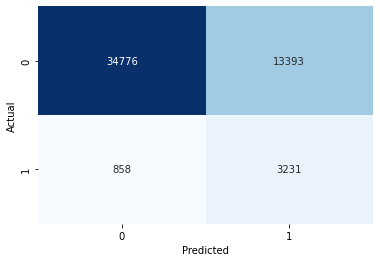

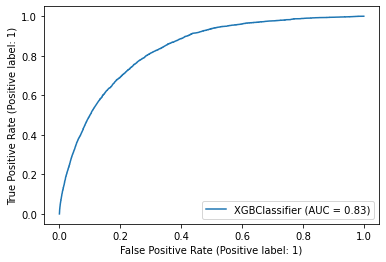

In [191]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# undersample training data
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# fit model on training data
best_model.fit(X_train_res, y_train_res)

# get predictions on test data
y_pred = best_model.predict(X_test)

# print scores
print('F1:', f1_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

# get classification report
print(classification_report(y_test, y_pred))

# get confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# plot roc curve
plot_roc_curve(best_model, X_test, y_test)
plt.show()

In [192]:
# build main model and save for deployment
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
best_model.fit(X_res, y_res)

# save model
pickle.dump(best_model, open('model.pkl', 'wb'))

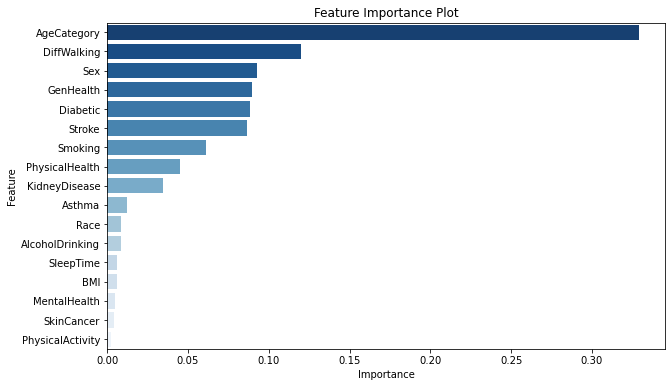

In [214]:
# feature importance plot
features_df = dict(zip(X.columns, best_model.feature_importances_))
features_df = {k: v for k, v in sorted(features_df.items(), key=lambda item: item[1], reverse=True)}
plt.figure(figsize=(10, 6))
sns.barplot(x=list(features_df.values()), y=list(features_df.keys()), palette='Blues_r')
plt.title('Feature Importance Plot')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [193]:
# save col_map_dict
pickle.dump(col_map_dict, open('col_map_dict.pkl', 'wb'))